#### Imports

In [ ]:
!pip install scikit-learn==1.0
!pip install lime
!pip install keras-tuner
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from keras.wrappers.scikit_learn import KerasRegressor
import keras_tuner as kt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from math import sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
import matplotlib.pyplot as plt
%matplotlib inline

##### Setting seeds for random number generators

In [ ]:
# tf.random.set_seed(42)
# np.random.seed(42)

In [ ]:
source_data = pd.read_csv('./final-data/indicators_source_infy.csv', index_col=[0])
target_data = pd.read_csv('./final-data/indicators_target.csv', index_col=[0])
# source_data = pd.read_csv('./final-data/features_source_infy.csv')
# target_data = pd.read_csv('./final-data/features_target.csv')


In [ ]:
source_data

,Date,Adj Close,Volume,MACD_HIST,MACD,MACD_SIG,EMA,STOCH_D,STOCH_K,MOM,RSI,CCI
0,2000-01-03,84.892334,657536,3.649675,11.439567,7.789891,78.755529,22.171826,21.502604,-20.313176,39.324516,-27.982698
1,2000-01-04,91.578827,7191808,2.848926,11.351049,8.502123,80.098399,25.990460,27.776950,-19.577043,42.093708,-9.487801
2,2000-01-05,84.252632,21069440,2.421628,11.529158,9.107530,79.663687,24.419481,23.978890,-20.710650,43.490315,76.998107
3,2000-01-06,77.512390,10495616,1.645993,11.165022,9.519028,78.936845,27.541423,30.868430,-20.175163,43.490315,102.042166
4,2000-01-07,71.311401,971392,0.539145,10.192959,9.653814,80.349967,34.564812,48.847117,-21.042846,47.749998,134.457840
...,...,...,...,...,...,...,...,...,...,...,...,...
5416,2021-09-14,1671.338013,4945167,-5.283581,1.116199,6.399780,1665.732960,72.490739,79.435462,-11.795410,46.046545,-122.275241
5417,2021-09-15,1696.415649,4062344,-5.118903,0.001152,5.120055,1667.712489,76.807497,69.906132,4.956055,49.472406,-88.703423
5418,2021-09-16,1687.296509,3246568,-4.592891,-0.621060,3.971832,1668.975974,63.567226,41.360084,24.284790,45.234441,-53.604408
5419,2021-09-17,1676.442749,7454864,-3.774927,-0.746827,3.028100,1669.457701,45.314556,24.677452,2.180786,49.460841,-53.157759


In [ ]:
target_data

,Date,Adj Close,Volume,MACD_HIST,MACD,MACD_SIG,EMA,STOCH_D,STOCH_K,MOM,RSI,CCI
8,2018-02-08,229.684158,159340,-0.036938,-2.240530,-2.203592,231.122193,30.487937,42.409420,-3.751807,48.890640,67.105770
9,2018-02-09,228.139420,132285,0.194972,-1.959877,-2.154849,231.870541,43.952639,59.360765,-3.010608,47.048766,78.328729
10,2018-02-12,240.014648,319651,0.479636,-1.555304,-2.034940,232.017602,59.380118,76.370169,-3.668777,44.311282,44.027855
11,2018-02-14,240.690491,152694,0.629649,-1.247878,-1.877527,230.730054,73.628732,85.155262,-3.523941,42.181059,20.777239
12,2018-02-15,230.890991,92349,0.924272,-0.722187,-1.646459,232.320973,78.054149,72.637015,-10.040848,44.724799,-20.540133
...,...,...,...,...,...,...,...,...,...,...,...,...
891,2021-09-14,614.549988,79676,-2.379392,-2.955743,-0.576351,592.469159,48.846040,54.128938,50.349976,48.056715,-91.746178
892,2021-09-15,605.450012,52934,-2.205638,-3.333398,-1.127760,593.306634,51.915466,60.333010,35.700012,43.735549,-56.743725
893,2021-09-16,604.049988,53230,-2.191581,-3.867237,-1.675655,593.999753,60.665985,67.536007,35.349976,41.673465,-89.361581
894,2021-09-17,594.349976,42071,-1.584234,-3.655948,-2.071714,594.022348,58.654315,48.093928,18.199951,39.866858,-122.866559


#### Separating dates from source stock data

In [ ]:
source_dates = source_data['Date']
source_data.drop(labels=['Date'], axis=1, inplace=True)

#### Separating date from target stock data

In [ ]:
target_dates = target_data['Date']
target_data.drop(labels=['Date'], axis=1, inplace=True)
target_data

,Adj Close,Volume,MACD_HIST,MACD,MACD_SIG,EMA,STOCH_D,STOCH_K,MOM,RSI,CCI
8,229.684158,159340,-0.036938,-2.240530,-2.203592,231.122193,30.487937,42.409420,-3.751807,48.890640,67.105770
9,228.139420,132285,0.194972,-1.959877,-2.154849,231.870541,43.952639,59.360765,-3.010608,47.048766,78.328729
10,240.014648,319651,0.479636,-1.555304,-2.034940,232.017602,59.380118,76.370169,-3.668777,44.311282,44.027855
11,240.690491,152694,0.629649,-1.247878,-1.877527,230.730054,73.628732,85.155262,-3.523941,42.181059,20.777239
12,230.890991,92349,0.924272,-0.722187,-1.646459,232.320973,78.054149,72.637015,-10.040848,44.724799,-20.540133
...,...,...,...,...,...,...,...,...,...,...,...
891,614.549988,79676,-2.379392,-2.955743,-0.576351,592.469159,48.846040,54.128938,50.349976,48.056715,-91.746178
892,605.450012,52934,-2.205638,-3.333398,-1.127760,593.306634,51.915466,60.333010,35.700012,43.735549,-56.743725
893,604.049988,53230,-2.191581,-3.867237,-1.675655,593.999753,60.665985,67.536007,35.349976,41.673465,-89.361581
894,594.349976,42071,-1.584234,-3.655948,-2.071714,594.022348,58.654315,48.093928,18.199951,39.866858,-122.866559


In [ ]:
# temp
# dropping volume
source_data.drop(['Volume'], axis=1, inplace=True)
target_data.drop(['Volume'], axis=1, inplace=True)

#### Display columns of source stock data and target stock data

In [ ]:
source_data_columns = source_data.columns
target_data_columns = target_data.columns
print(source_data_columns, target_data_columns, sep='\n')

Index(['Adj Close', 'MACD_HIST', 'MACD', 'MACD_SIG', 'EMA', 'STOCH_D',
       'STOCH_K', 'MOM', 'RSI', 'CCI'],
      dtype='object')
Index(['Adj Close', 'MACD_HIST', 'MACD', 'MACD_SIG', 'EMA', 'STOCH_D',
       'STOCH_K', 'MOM', 'RSI', 'CCI'],
      dtype='object')


#### Normalizing features

In [ ]:
source_scaler = MinMaxScaler(feature_range=(0, 1))
source_scaler = source_scaler.fit(source_data.values)
source_data = source_scaler.transform(source_data.values)
source_data = pd.DataFrame(source_data, columns=source_data_columns)
source_data

,Adj Close,MACD_HIST,MACD,MACD_SIG,EMA,STOCH_D,STOCH_K,MOM,RSI,CCI
0,0.035864,0.699671,0.615329,0.550145,0.029781,0.200499,0.214498,0.485720,0.351804,0.438881
1,0.039791,0.674639,0.614412,0.558735,0.030600,0.240417,0.277284,0.487665,0.391641,0.460767
2,0.035488,0.661281,0.616258,0.566036,0.030335,0.223995,0.239277,0.484669,0.411733,0.563108
3,0.031529,0.637034,0.612483,0.571000,0.029892,0.256630,0.308219,0.486084,0.411733,0.592743
4,0.027887,0.602434,0.602406,0.572625,0.030753,0.330048,0.488127,0.483791,0.473011,0.631102
...,...,...,...,...,...,...,...,...,...,...
5416,0.967688,0.420411,0.508307,0.533378,0.997588,0.726503,0.794216,0.508234,0.448506,0.327302
5417,0.982417,0.425559,0.496747,0.517944,0.998795,0.771628,0.698859,0.552513,0.497789,0.367028
5418,0.977061,0.442003,0.490296,0.504095,0.999566,0.633222,0.413206,0.603604,0.436823,0.408562
5419,0.970686,0.467573,0.488993,0.492713,0.999860,0.442420,0.246268,0.545177,0.497623,0.409091


In [ ]:
target_scaler = MinMaxScaler(feature_range=(0, 1))
target_scaler = target_scaler.fit(target_data.values)
target_data = target_scaler.transform(target_data.values)
target_data = pd.DataFrame(target_data, columns=target_data_columns)
target_data

,Adj Close,MACD_HIST,MACD,MACD_SIG,EMA,STOCH_D,STOCH_K,MOM,RSI,CCI
0,0.209506,0.549931,0.238418,0.231716,0.218680,0.305459,0.460281,0.353719,0.486069,0.556081
1,0.207071,0.558183,0.241731,0.232351,0.220224,0.458798,0.644259,0.356113,0.461986,0.568818
2,0.225790,0.568311,0.246507,0.233914,0.220527,0.634490,0.828867,0.353987,0.426194,0.529889
3,0.226855,0.573649,0.250136,0.235966,0.217871,0.796756,0.924214,0.354455,0.398342,0.503502
4,0.211409,0.584132,0.256341,0.238979,0.221153,0.847154,0.788350,0.333403,0.431601,0.456610
...,...,...,...,...,...,...,...,...,...,...
883,0.816168,0.466584,0.229975,0.252930,0.964036,0.514525,0.587477,0.528487,0.475165,0.375798
884,0.801824,0.472766,0.225517,0.245741,0.965764,0.549481,0.654811,0.481162,0.418667,0.415522
885,0.799617,0.473266,0.219215,0.238598,0.967193,0.649133,0.732987,0.480032,0.391705,0.378504
886,0.784327,0.494876,0.221710,0.233435,0.967240,0.626224,0.521977,0.424631,0.368084,0.340479


#### Separating target variable from features for source stock data

In [ ]:
source_labels = source_data['Adj Close']
source_data.drop(labels=['Adj Close'], axis=1, inplace=True)
source_features = source_data
source_features

,MACD_HIST,MACD,MACD_SIG,EMA,STOCH_D,STOCH_K,MOM,RSI,CCI
0,0.699671,0.615329,0.550145,0.029781,0.200499,0.214498,0.485720,0.351804,0.438881
1,0.674639,0.614412,0.558735,0.030600,0.240417,0.277284,0.487665,0.391641,0.460767
2,0.661281,0.616258,0.566036,0.030335,0.223995,0.239277,0.484669,0.411733,0.563108
3,0.637034,0.612483,0.571000,0.029892,0.256630,0.308219,0.486084,0.411733,0.592743
4,0.602434,0.602406,0.572625,0.030753,0.330048,0.488127,0.483791,0.473011,0.631102
...,...,...,...,...,...,...,...,...,...
5416,0.420411,0.508307,0.533378,0.997588,0.726503,0.794216,0.508234,0.448506,0.327302
5417,0.425559,0.496747,0.517944,0.998795,0.771628,0.698859,0.552513,0.497789,0.367028
5418,0.442003,0.490296,0.504095,0.999566,0.633222,0.413206,0.603604,0.436823,0.408562
5419,0.467573,0.488993,0.492713,0.999860,0.442420,0.246268,0.545177,0.497623,0.409091


#### Separating target variables from features for target stock data

In [ ]:
target_labels = target_data['Adj Close']
target_data.drop(labels=['Adj Close'], axis=1, inplace=True)
target_features = target_data
target_features

,MACD_HIST,MACD,MACD_SIG,EMA,STOCH_D,STOCH_K,MOM,RSI,CCI
0,0.549931,0.238418,0.231716,0.218680,0.305459,0.460281,0.353719,0.486069,0.556081
1,0.558183,0.241731,0.232351,0.220224,0.458798,0.644259,0.356113,0.461986,0.568818
2,0.568311,0.246507,0.233914,0.220527,0.634490,0.828867,0.353987,0.426194,0.529889
3,0.573649,0.250136,0.235966,0.217871,0.796756,0.924214,0.354455,0.398342,0.503502
4,0.584132,0.256341,0.238979,0.221153,0.847154,0.788350,0.333403,0.431601,0.456610
...,...,...,...,...,...,...,...,...,...
883,0.466584,0.229975,0.252930,0.964036,0.514525,0.587477,0.528487,0.475165,0.375798
884,0.472766,0.225517,0.245741,0.965764,0.549481,0.654811,0.481162,0.418667,0.415522
885,0.473266,0.219215,0.238598,0.967193,0.649133,0.732987,0.480032,0.391705,0.378504
886,0.494876,0.221710,0.233435,0.967240,0.626224,0.521977,0.424631,0.368084,0.340479


Each GRU layer requires input in the form of 3D numpy array.  
The array dimensions are used as follows:  
`[Number of samples, number of time steps, number of features]`  
To have array an length which can be used to create such dimensions,    
we will be limiting the number of records to a multiple of 100.

In [ ]:
print(f"Count of source features = {len(source_features)}, Count of target features = {len(target_features)}")

Count of source features = 5421, Count of target features = 888


In [ ]:
source_features = source_features.iloc[0:len(source_features)-len(source_features)%100]
source_labels = source_labels.iloc[0:len(source_labels)-len(source_labels)%100]
target_features = target_features.iloc[0:len(target_features)-len(target_features)%100]
target_labels = target_labels.iloc[0:len(target_labels)-len(target_labels)%100]
print(f"Count of source features = {len(source_features)} Count of target features = {len(target_features)}")

Count of source features = 5400 Count of target features = 800


In [ ]:
def ts_train_test_split(data, train_size, time_window=1, for_period=1):
    '''
    data: A  dataframe, with label to be predicted as first column.
    train_size is a floating value which specifies the size of the train dataset.
    For a 70:30 split, pass 0.7 as the argument for train_size,
    For a 80:20 split, pass 0.8 as the argument for train_size.
    time_window > for_period
    '''
    data_columns = data.columns
    train_data = data[:int(len(data) * train_size)]
    test_data = data[int(len(data) * train_size):]
    
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []
    
    train_len = len(train_data)
    for row in range(time_window, train_len-for_period):
        X_train.append(np.array(train_data.iloc[row-time_window:row,:]))
    for row in range(time_window, train_len-for_period):
        Y_train.append(np.array(train_data.iloc[row:row+for_period,0]))
    
    test_len = len(test_data)
    for row in range(time_window, test_len-for_period):
        X_test.append(np.array(test_data.iloc[row-time_window:row,:]))
    for row in range(time_window, test_len-for_period):
        Y_test.append(np.array(test_data.iloc[row:row+for_period,0]))
    
    return np.array(X_train), np.array(X_test), np.array(Y_train), np.array(Y_test)

look_back = 10
X_train_gru_source, X_test_gru_source, Y_train_gru_source, Y_test_gru_source = ts_train_test_split(source_data, 0.7, look_back, 1)

### Training GRU model on source data

In [ ]:
X_train_gru_source, X_test_gru_source, Y_train_gru_source, Y_test_gru_source = train_test_split(source_features, source_labels, test_size=0.30, random_state=42, shuffle=False)

In [ ]:
X_train_gru_source = np.array(X_train_gru_source)
X_test_gru_source = np.array(X_test_gru_source)
Y_train_gru_source = np.array(Y_train_gru_source)
Y_test_gru_source = np.array(Y_test_gru_source)

In [ ]:
X_train_gru_source = X_train_gru_source.reshape(X_train_gru_source.shape[0], X_train_gru_source.shape[1], 1)
X_test_gru_source = X_test_gru_source.reshape(X_test_gru_source.shape[0], X_test_gru_source.shape[1], 1)
# Y_train_gru_source =  Y_train_gru_source.reshape(-1, time_window_size, 1)
# Y_test_gru_source =  Y_test_gru_source.reshape(-1, time_window_size, 1)

look_back = X_train_gru_source.shape[1]
feature_count = X_train_gru_source.shape[2]

X_train_gru_source = X_train_gru_source.reshape(-1, look_back, feature_count)
X_test_gru_source = X_test_gru_source.reshape(-1, look_back, feature_count)
# Y_train_gru_source =  Y_train_gru_source.reshape(-1, time_window_size, 1)
# Y_test_gru_source =  Y_test_gru_source.reshape(-1, time_window_size, 1)

#### Obtaining number of features

In [ ]:
feature_count = len(source_features.columns)

# See above 'Obtaining number of features'

#### Setting batch size

batch_size=3

#### Finding best hyperparams for source model

*Callback function used by tuner for early stopping*

In [ ]:
# patience is the number of epochs tolerated without an improvement in the loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_percentage_error', patience=5)

In [ ]:
"""
Function used by Hyperband for hyperparameter tuning.
Returns a model.
"""
def source_model_builder(hp):                                           
    model = Sequential()
    """
    A Sequential gru_model_source is appropriate for a plain stack
    of layers where each layer has exactly one input tensor and
    one output tensor.
    """ 
    hp_unit = hp.Int('units', min_value=12, max_value=64, step=2)
    
    model.add(GRU(units=hp_unit, return_sequences=True,input_shape=(feature_count, 1)))
    model.add(GRU(units=hp_unit,return_sequences=True))
    model.add(GRU(units=hp_unit))
    model.add(Dense(1, activation="relu"))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(), loss="mse", metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])
    
    return model

"""
Function used by Hyperband for hyperparameter tuning.
Returns a model.
"""
def source_model_builder(hp):                                           
    model = Sequential()
    """
    A Sequential gru_model_source is appropriate for a plain stack
    of layers where each layer has exactly one input tensor and
    one output tensor.
    """ 
    hp_unit = hp.Int('units', min_value=16, max_value=128, step=16)
    
    model.add(GRU(units=hp_unit, return_sequences=True,batch_input_shape=(batch_size, look_back, feature_count), stateful=True))
    model.add(GRU(units=hp_unit,return_sequences=True, stateful=True))
    model.add(GRU(units=hp_unit, stateful=True))
    model.add(Dense(1, kernel_initializer="uniform", activation="relu"))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss="mse", metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])
    
    return model

In [ ]:
# pass the argument overWrite=True to avoid reusing results.
source_tuner = kt.Hyperband(source_model_builder,
                     objective='mean_absolute_percentage_error',
                     max_epochs=250,
                     factor=2,
                     seed=42,
                     hyperband_iterations=3,
                     directory='hyperparams',
                     project_name='source_stock_1', overwrite=True)

# pass the argument overwrite=True to avoid reusing results.
source_tuner = kt.Hyperband(source_model_builder,
                     objective='loss',
                     max_epochs=80,
                     factor=2,
                     seed=42,
                     hyperband_iterations=3,
                     directory='hyperparams',
                     project_name='source_stock_1',
                     overwrite=True)

See: [https://keras.io/api/keras_tuner/tuners/hyperband/](https://keras.io/api/keras_tuner/tuners/hyperband/)

In [ ]:
source_tuner.search(X_train_gru_source, Y_train_gru_source, epochs=250)

# Get the optimal hyperparameters
source_best_hps=source_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the GRU layer
is {source_best_hps.get('units')}.
""")


Trial 25 Complete [00h 00m 11s]
mean_absolute_percentage_error: 25719.908203125

Best mean_absolute_percentage_error So Far: 99.97354125976562
Total elapsed time: 00h 04m 58s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the GRU layer
is 46.



X_train_gru_source.shape

Y_train_gru_source.shape

source_tuner.search(X_train_gru_source, Y_train_gru_source, epochs=100, batch_size=batch_size)

# Get the optimal hyperparameters
source_best_hps=source_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the GRU layer
is {source_best_hps.get('units')}.
""")


gru_model_source = source_tuner.hypermodel.build(source_best_hps)
gru_model_source.fit(X_train_gru_source, Y_train_gru_source, epochs=200, verbose=1, batch_size=3)

In [ ]:
gru_model_source = Sequential()
#A Sequential gru_model_source is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.
gru_model_source.add(GRU(46, return_sequences=True,input_shape=(feature_count,1)))
gru_model_source.add(GRU(46))
gru_model_source.add(Dense(1, activation="relu"))
gru_model_source.compile(optimizer=tf.keras.optimizers.Adam(), loss='mean_squared_error', metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])

In [ ]:
gru_model_source.fit(X_train_gru_source,Y_train_gru_source,epochs=200,verbose=1)

Epoch 1/200
119/119 [==============================] - 6s 13ms/step - loss: 0.0043 - mean_absolute_error: 0.0550 - mean_absolute_percentage_error: 5973.7827
Epoch 2/200
119/119 [==============================] - 2s 13ms/step - loss: 0.0038 - mean_absolute_error: 0.0528 - mean_absolute_percentage_error: 26245.9258
Epoch 3/200
119/119 [==============================] - 2s 13ms/step - loss: 0.0037 - mean_absolute_error: 0.0522 - mean_absolute_percentage_error: 28830.6113
Epoch 4/200
119/119 [==============================] - 2s 13ms/step - loss: 0.0037 - mean_absolute_error: 0.0518 - mean_absolute_percentage_error: 19210.3633
Epoch 5/200
119/119 [==============================] - 1s 12ms/step - loss: 0.0032 - mean_absolute_error: 0.0471 - mean_absolute_percentage_error: 12534.1572
Epoch 6/200
119/119 [==============================] - 1s 13ms/step - loss: 0.0014 - mean_absolute_error: 0.0288 - mean_absolute_percentage_error: 11528.2012
Epoch 7/200
119/119 [==============================] 

In [ ]:
Y_pred_test_gru_source = gru_model_source.predict(X_test_gru_source)
Y_pred_train_gru_source = gru_model_source.predict(X_train_gru_source)

Y_pred_test_gru_source = gru_model_source.predict(X_test_gru_source, batch_size=3)
Y_pred_train_gru_source = gru_model_source.predict(X_train_gru_source, batch_size=3)

In [ ]:
# Calculating RMSE
test_rmse_gru_source = sqrt(mean_squared_error(Y_pred_test_gru_source, Y_test_gru_source))
train_rmse_gru_source = sqrt(mean_squared_error(Y_pred_train_gru_source, Y_train_gru_source))
print("test_rmse_gru_source = {}, train_rmse_gru_source = {}".format(test_rmse_gru_source, train_rmse_gru_source))

# Calculating r2_score
test_r2_score_gru_source = r2_score(Y_test_gru_source, Y_pred_test_gru_source)
train_r2_score_gru_source = r2_score(Y_train_gru_source, Y_pred_train_gru_source)
print("test_r2_score_gru_source = {}, train_r2_score_gru_source = {}".format(test_r2_score_gru_source, train_r2_score_gru_source))

# Calculating MAE
test_mae_gru_source = mean_absolute_error(Y_test_gru_source, Y_pred_test_gru_source)
train_mae_gru_source = mean_absolute_error(Y_train_gru_source, Y_pred_train_gru_source)
print("test_mae_gru_source = {}, train_mae_gru_source = {}".format(test_mae_gru_source, train_mae_gru_source))

# Calculating MAPE
test_loss_gru_source, test_mae_gru_source, test_mape_gru_source = gru_model_source.evaluate(X_test_gru_source, Y_test_gru_source, verbose=0)
train_loss_gru_source, train_mae_gru_source, train_mape_gru_source = gru_model_source.evaluate(X_train_gru_source, Y_train_gru_source, verbose=0)
print("test_mape_gru_source = {}, train_mape_gru_source = {}".format(test_mape_gru_source, train_mape_gru_source))

test_rmse_gru_source = 0.06234329582105105, train_rmse_gru_source = 0.006231297819111162
test_r2_score_gru_source = 0.8694539695928973, train_r2_score_gru_source = 0.9897757232109614
test_mae_gru_source = 0.03062937733180197, train_mae_gru_source = 0.0055993543127201666
test_mape_gru_source = 5.460618019104004, train_mape_gru_source = 18.783916473388672


# Calculating RMSE
test_rmse_gru_source = sqrt(mean_squared_error(Y_pred_test_gru_source, Y_test_gru_source))
train_rmse_gru_source = sqrt(mean_squared_error(Y_pred_train_gru_source, Y_train_gru_source))
print("test_rmse_gru_source = {}, train_rmse_gru_source = {}".format(test_rmse_gru_source, train_rmse_gru_source))

# Calculating r2_score
test_r2_score_gru_source = r2_score(Y_test_gru_source, Y_pred_test_gru_source)
train_r2_score_gru_source = r2_score(Y_train_gru_source, Y_pred_train_gru_source)
print("test_r2_score_gru_source = {}, train_r2_score_gru_source = {}".format(test_r2_score_gru_source, train_r2_score_gru_source))

# Calculating MAE
test_mae_gru_source = mean_absolute_error(Y_test_gru_source, Y_pred_test_gru_source)
train_mae_gru_source = mean_absolute_error(Y_train_gru_source, Y_pred_train_gru_source)
print("test_mae_gru_source = {}, train_mae_gru_source = {}".format(test_mae_gru_source, train_mae_gru_source))

# Calculating MAPE
test_loss_gru_source, test_mae_gru_source, test_mape_gru_source = gru_model_source.evaluate(X_test_gru_source, Y_test_gru_source, batch_size=3, verbose=0)
train_loss_gru_source, train_mae_gru_source, train_mape_gru_source = gru_model_source.evaluate(X_train_gru_source, Y_train_gru_source, batch_size=3, verbose=0)
print("test_mape_gru_source = {}, train_mape_gru_source = {}".format(test_mape_gru_source, train_mape_gru_source))

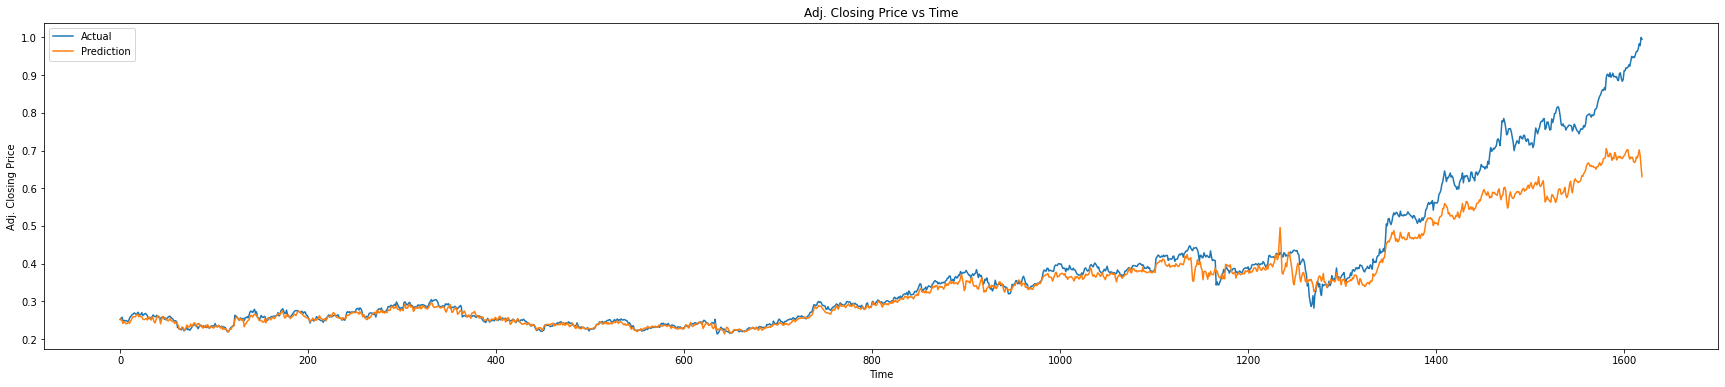

In [ ]:
plt.figure(1, figsize=(30, 6)) # Defines the figure size in inches
plt.plot(range(0, len(Y_test_gru_source)), Y_test_gru_source)
plt.plot(range(0, len(Y_test_gru_source)), Y_pred_test_gru_source)
plt.xlabel('Time')
plt.ylabel('Adj. Closing Price')
plt.title('Adj. Closing Price vs Time')
plt.legend(['Actual', 'Prediction'])

In [ ]:
last_layer_source = gru_model_source.get_layer(index=2)
last_layer_source.get_weights()

[array([[ 1.47355288e-01],
        [ 2.54686587e-02],
        [ 5.06820194e-02],
        [-8.51354271e-05],
        [-1.07288964e-01],
        [ 9.17046517e-03],
        [-1.46972135e-01],
        [ 8.85297507e-02],
        [-1.00829015e-02],
        [ 1.08474560e-01],
        [-7.97062218e-02],
        [-7.74076581e-02],
        [ 3.19066606e-02],
        [-4.70993249e-03],
        [-8.16711597e-03],
        [ 8.41367543e-02],
        [ 5.79706281e-02],
        [-2.08118884e-03],
        [ 2.12578401e-02],
        [-1.43360630e-01],
        [-2.85994917e-01],
        [ 1.49318650e-01],
        [ 1.77483693e-01],
        [-4.84818853e-02],
        [-1.41827643e-01],
        [-2.32756153e-01],
        [-3.39195807e-03],
        [-2.29812026e-01],
        [ 8.59042257e-02],
        [-1.57577038e-01],
        [ 7.70951137e-02],
        [-1.34852782e-01],
        [-1.14205904e-01],
        [ 9.05060992e-02],
        [-1.07305393e-01],
        [ 2.51137078e-01],
        [-1.49131879e-01],
 

#### Training source model on another stock having sufficient data

In [ ]:
second_source_data = pd.read_csv('./final-data/indicators_source_tcs.csv', index_col=[0])

In [ ]:
adj_close_second_source = second_source_data['Adj Close']

In [ ]:
second_source_data.drop(['Date'], axis=1, inplace=True)

In [ ]:
# temp
# Dropping volume
second_source_data.drop(['Volume'], axis=1, inplace=True)

In [ ]:
second_source_values = second_source_data.values
second_scaler = MinMaxScaler(feature_range=(0, 1))
second_scaler = second_scaler.fit(second_source_values)
normalized_second_source_values = second_scaler.transform(second_source_values)

In [ ]:
normalized_second_source = pd.DataFrame(normalized_second_source_values, columns=second_source_data.columns)

In [ ]:
label_normalized_second_source = normalized_second_source['Adj Close']
normalized_second_source.drop(['Adj Close'], axis=1, inplace=True)

In [ ]:
features_normalized_second_source = normalized_second_source

In [ ]:
X_train_gru_second_source, X_test_gru_second_source, Y_train_gru_second_source, Y_test_gru_second_source = train_test_split(features_normalized_second_source, label_normalized_second_source, test_size=0.30, random_state=42, shuffle=False)

In [ ]:
Y_train_gru_second_source.shape

(3118,)

In [ ]:
X_train_gru_second_source = np.array(X_train_gru_second_source)
X_test_gru_second_source = np.array(X_test_gru_second_source)
Y_train_gru_second_source = np.array(Y_train_gru_second_source)
Y_test_gru_second_source = np.array(Y_test_gru_second_source)

In [ ]:
X_train_gru_second_source = X_train_gru_second_source.reshape(X_train_gru_second_source.shape[0],X_train_gru_second_source.shape[1],1)
X_test_gru_second_source = X_test_gru_second_source.reshape(X_test_gru_second_source.shape[0],X_test_gru_second_source.shape[1],1)

In [ ]:
history_gru_second_source = gru_model_source.fit(X_train_gru_second_source,Y_train_gru_second_source,validation_data=(X_test_gru_second_source,Y_test_gru_second_source),epochs=200,verbose=1)
Y_pred_test_gru_second_source = gru_model_source.predict(X_test_gru_second_source)
Y_pred_train_gru_second_source = gru_model_source.predict(X_train_gru_second_source)

Epoch 1/200
98/98 [==============================] - 1s 14ms/step - loss: 2.3278e-05 - mean_absolute_error: 0.0034 - mean_absolute_percentage_error: 181.9644 - val_loss: 0.0082 - val_mean_absolute_error: 0.0532 - val_mean_absolute_percentage_error: 8.3447
Epoch 2/200
98/98 [==============================] - 1s 15ms/step - loss: 1.5212e-05 - mean_absolute_error: 0.0029 - mean_absolute_percentage_error: 1400.3359 - val_loss: 0.0092 - val_mean_absolute_error: 0.0584 - val_mean_absolute_percentage_error: 9.2938
Epoch 3/200
98/98 [==============================] - 1s 15ms/step - loss: 1.6598e-05 - mean_absolute_error: 0.0031 - mean_absolute_percentage_error: 60.9659 - val_loss: 0.0087 - val_mean_absolute_error: 0.0558 - val_mean_absolute_percentage_error: 8.7683
Epoch 4/200
98/98 [==============================] - 1s 15ms/step - loss: 1.2168e-05 - mean_absolute_error: 0.0026 - mean_absolute_percentage_error: 1351.8718 - val_loss: 0.0088 - val_mean_absolute_error: 0.0571 - val_mean_absolute_

In [ ]:
# Calculating RMSE
test_rmse_gru_second_source = sqrt(mean_squared_error(Y_pred_test_gru_second_source, Y_test_gru_second_source))
train_rmse_gru_second_source = sqrt(mean_squared_error(Y_pred_train_gru_second_source, Y_train_gru_second_source))
print("test_rmse_gru_second_source = {}, train_rmse_gru_second_source = {}".format(test_rmse_gru_second_source, train_rmse_gru_second_source))

# Calculating r2_score
test_r2_score_gru_second_source = r2_score(Y_test_gru_second_source, Y_pred_test_gru_second_source)
train_r2_score_gru_second_source = r2_score(Y_train_gru_second_source, Y_pred_train_gru_second_source)
print("test_r2_score_gru_second_source = {}, train_r2_score_gru_second_source = {}".format(test_r2_score_gru_second_source, train_r2_score_gru_second_source))

# Calculating MAE
test_mae_gru_second_source = mean_absolute_error(Y_test_gru_second_source, Y_pred_test_gru_second_source)
train_mae_gru_second_source = mean_absolute_error(Y_train_gru_second_source, Y_pred_train_gru_second_source)
print("test_mae_gru_second_source = {}, train_mae_gru_second_source = {}".format(test_mae_gru_second_source, train_mae_gru_second_source))

# Calculating MAPE
test_loss_gru_second_source, test_mae_gru_second_source, test_mape_gru_second_source = gru_model_source.evaluate(X_test_gru_second_source, Y_test_gru_second_source, verbose=0)
train_loss_gru_second_source, train_mae_gru_second_source, train_mape_gru_second_source = gru_model_source.evaluate(X_train_gru_second_source, Y_train_gru_second_source, verbose=0)
print("test_mape_gru_second_source = {}, train_mape_gru_second_source = {}".format(test_mape_gru_second_source, train_mape_gru_second_source))

test_rmse_gru_second_source = 0.10280989954217593, train_rmse_gru_second_source = 0.003244253072494634
test_r2_score_gru_second_source = 0.6713380807178253, train_r2_score_gru_second_source = 0.9987163420049869
test_mae_gru_second_source = 0.06362778056538043, train_mae_gru_second_source = 0.002564240971687496
test_mape_gru_second_source = 10.053621292114258, train_mape_gru_second_source = 1102.6890869140625


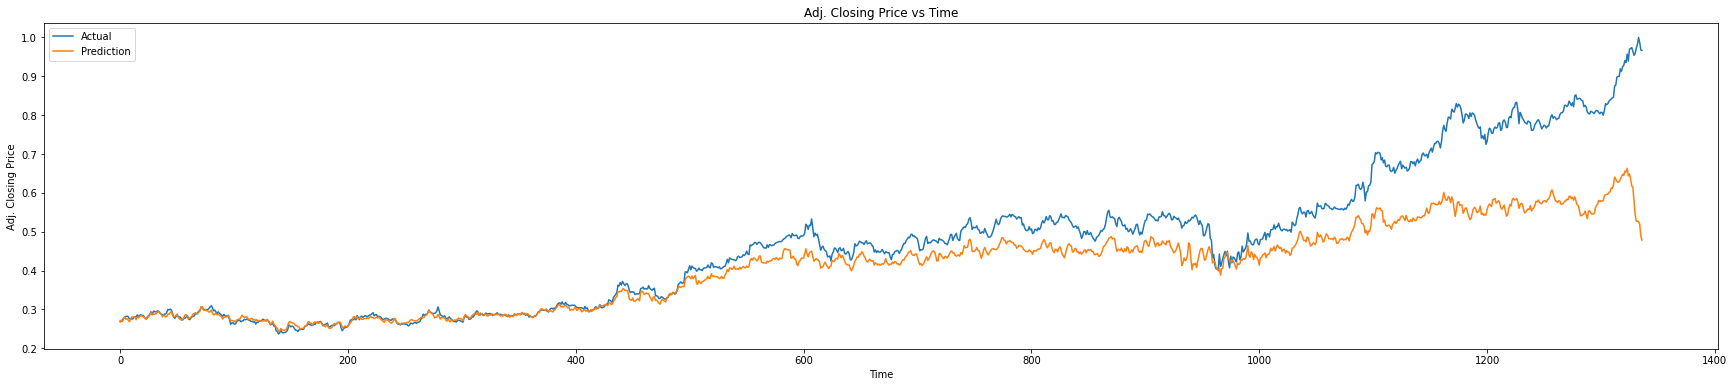

In [ ]:
plt.figure(1, figsize=(30, 6)) # Defines the figure size in inches
plt.plot(range(0, len(Y_test_gru_second_source)), Y_test_gru_second_source)
plt.plot(range(0, len(Y_test_gru_second_source)), Y_pred_test_gru_second_source)
plt.xlabel('Time')
plt.ylabel('Adj. Closing Price')
plt.title('Adj. Closing Price vs Time')
plt.legend(['Actual', 'Prediction'])

### Transfer Learning

In [ ]:
print("weights:", len(gru_model_source.weights))
print("trainable_weights:", len(gru_model_source.trainable_weights))
print("non_trainable_weights:", len(gru_model_source.non_trainable_weights))

weights: 8
trainable_weights: 8
non_trainable_weights: 0


In [ ]:
'''
Freezing weights. Instance-based transfer learning.
'''
gru_model_source.trainable = False

#### Train-test split for target stock data

In [ ]:
X_train_gru_target, X_test_gru_target, Y_train_gru_target, Y_test_gru_target = train_test_split(target_features, target_labels, test_size=0.30, random_state=42, shuffle=False)

In [ ]:
X_train_gru_target = np.array(X_train_gru_target)
X_test_gru_target = np.array(X_test_gru_target)
Y_train_gru_target = np.array(Y_train_gru_target)
Y_test_gru_target = np.array(Y_test_gru_target)

In [ ]:
X_train_gru_target = X_train_gru_target.reshape(X_train_gru_target.shape[0],X_train_gru_target.shape[1],1)
X_test_gru_target = X_test_gru_target.reshape(X_test_gru_target.shape[0],X_test_gru_target.shape[1],1)

In [ ]:
Y_test_gru_target.shape

(240,)

In [ ]:
X_train_gru_target.shape

(560, 9, 1)

In [ ]:
def target_model_builder(hp):                                           
    model = Sequential()
    model.add(gru_model_source.layers[0])
    
    hp_unit = hp.Int('units', min_value=12, max_value=64, step=2)
    model.add(GRU(units=hp_unit, return_sequences=True, name="layer-2"))
    model.add(GRU(units=hp_unit, name="layer-3"))
    model.add(Dense(1, activation="relu", name="layer-4"))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss="mse", metrics=['mean_absolute_percentage_error'])
    return model

In [ ]:
target_tuner = kt.Hyperband(target_model_builder,
                     objective='mean_absolute_percentage_error',
                     max_epochs=200,
                     factor=2,
                     seed=42,
                     hyperband_iterations=3,
                     directory='hyperparams',
                     project_name='target_stock')

INFO:tensorflow:Reloading Oracle from existing project hyperparams/target_stock/oracle.json
INFO:tensorflow:Reloading Tuner from hyperparams/target_stock/tuner0.json


In [ ]:
target_tuner.search(X_train_gru_target, Y_train_gru_target, epochs=250)

Trial 144 Complete [00h 00m 06s]
mean_absolute_percentage_error: 99.82142639160156

Best mean_absolute_percentage_error So Far: 0.0013360745506361127
Total elapsed time: 00h 16m 37s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Get the optimal hyperparameters
best_hps_target=target_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps_target.get('units')} and the
optimal learning rate for the optimizer
is {best_hps_target.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 46 and the
optimal learning rate for the optimizer
is 0.01.



In [ ]:
gru_model_target = Sequential()
gru_model_target.add(gru_model_source.layers[0])
gru_model_target.add(GRU(units=46, return_sequences=True, name="second"))
gru_model_target.add(GRU(units=46, name="third"))
gru_model_target.add(Dense(1, activation="relu", name="fourth"))
gru_model_target.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='mean_squared_error', metrics=['mean_absolute_percentage_error'])

In [ ]:
gru_model_target.fit(X_train_gru_target,Y_train_gru_target,epochs=200,verbose=1)

Epoch 1/200
18/18 [==============================] - 5s 14ms/step - loss: 0.0150 - mean_absolute_percentage_error: 160703.0625
Epoch 2/200
18/18 [==============================] - 0s 14ms/step - loss: 0.0011 - mean_absolute_percentage_error: 51278.2695
Epoch 3/200
18/18 [==============================] - 0s 15ms/step - loss: 6.1277e-04 - mean_absolute_percentage_error: 81308.3750
Epoch 4/200
18/18 [==============================] - 0s 14ms/step - loss: 4.3615e-04 - mean_absolute_percentage_error: 52745.3203
Epoch 5/200
18/18 [==============================] - 0s 13ms/step - loss: 3.7325e-04 - mean_absolute_percentage_error: 34459.6875
Epoch 6/200
18/18 [==============================] - 0s 14ms/step - loss: 3.6726e-04 - mean_absolute_percentage_error: 16673.9062
Epoch 7/200
18/18 [==============================] - 0s 14ms/step - loss: 3.5081e-04 - mean_absolute_percentage_error: 34205.2031
Epoch 8/200
18/18 [==============================] - 0s 13ms/step - loss: 3.2123e-04 - mean_absol

In [ ]:
Y_pred_test_gru_target = gru_model_target.predict(X_test_gru_target)
Y_pred_train_gru_target = gru_model_target.predict(X_train_gru_target)

In [ ]:
Y_test_gru_target.shape

(240,)

In [ ]:
Y_pred_test_gru_target.shape

(240, 1)

In [ ]:
# Calculating RMSE
test_rmse_gru_target = sqrt(mean_squared_error(Y_pred_test_gru_target, Y_test_gru_target))
train_rmse_gru_target = sqrt(mean_squared_error(Y_pred_train_gru_target, Y_train_gru_target))
print("test_rmse_gru_target = {}, train_rmse_gru_target = {}".format(test_rmse_gru_target, train_rmse_gru_target))

# Calculating r2_score
test_r2_score_gru_target = r2_score(Y_test_gru_target, Y_pred_test_gru_target)
train_r2_score_gru_target = r2_score(Y_train_gru_target, Y_pred_train_gru_target)
print("test_r2_score_gru_target = {}, train_r2_score_gru_target = {}".format(test_r2_score_gru_target , train_r2_score_gru_target))

# Calculating MAE
test_mae_gru_target = mean_absolute_error(Y_test_gru_target,Y_pred_test_gru_target)
train_mae_gru_target = mean_absolute_error(Y_train_gru_target,Y_pred_train_gru_target)
print("test_mae_gru_target = {}, train_mae_gru_target = {}".format(test_mae_gru_target , train_mae_gru_target))

# Calculating MAPE
test_loss_gru_target, test_mape_gru_target = gru_model_target.evaluate(X_test_gru_target, Y_test_gru_target, verbose=0)
train_loss_gru_target, train_mape_gru_target = gru_model_target.evaluate(X_train_gru_target, Y_train_gru_target, verbose=0)
print("test_mape_gru_target = {}, train_mape_gru_target = {}".format(test_mape_gru_target, train_mape_gru_target))

test_rmse_gru_target = 0.021798185257854014, train_rmse_gru_target = 0.011966587068149607
test_r2_score_gru_target = 0.9394955819801658, train_r2_score_gru_target = 0.9805900843275854
test_mae_gru_target = 0.017907410501950476, train_mae_gru_target = 0.009307187520787975
test_mape_gru_target = 11.773886680603027, train_mape_gru_target = 7.1098408699035645


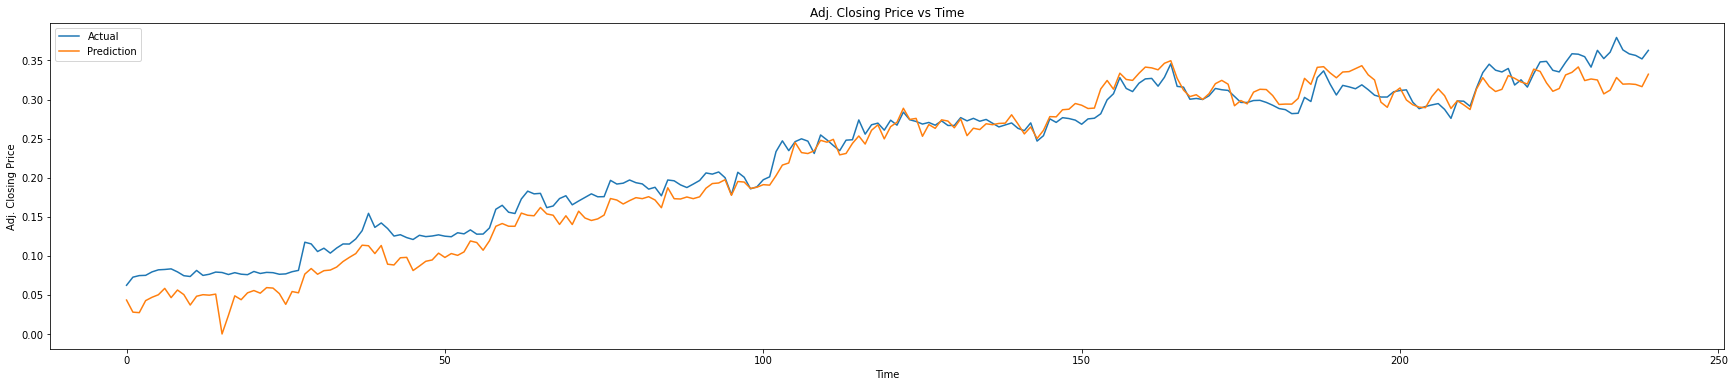

In [ ]:
plt.figure(1, figsize=(30, 6)) # Defines the figure size in inches
plt.plot(range(0, len(Y_test_gru_target)), Y_test_gru_target)
plt.plot(range(0, len(Y_test_gru_target)), Y_pred_test_gru_target)
plt.xlabel('Time')
plt.ylabel('Adj. Closing Price')
plt.title('Adj. Closing Price vs Time')
plt.legend(['Actual', 'Prediction'])

#### Unfreezing weights of source model

In [ ]:
gru_model_source.trainable = True

#### Setting a small learning rate for the target model

In [ ]:
from keras import backend as K
K.set_value(gru_model_target.optimizer.learning_rate, 0.0001)

In [ ]:
gru_model_target.fit(X_train_gru_target, Y_train_gru_target, epochs=200,verbose=1)

Epoch 1/200
18/18 [==============================] - 0s 14ms/step - loss: 1.3061e-04 - mean_absolute_percentage_error: 6.9254
Epoch 2/200
18/18 [==============================] - 0s 14ms/step - loss: 1.0091e-04 - mean_absolute_percentage_error: 6.4355
Epoch 3/200
18/18 [==============================] - 0s 14ms/step - loss: 9.6610e-05 - mean_absolute_percentage_error: 6.3255
Epoch 4/200
18/18 [==============================] - 0s 14ms/step - loss: 9.5426e-05 - mean_absolute_percentage_error: 6.2471
Epoch 5/200
18/18 [==============================] - 0s 14ms/step - loss: 9.4515e-05 - mean_absolute_percentage_error: 6.2163
Epoch 6/200
18/18 [==============================] - 0s 14ms/step - loss: 9.4428e-05 - mean_absolute_percentage_error: 6.1956
Epoch 7/200
18/18 [==============================] - 0s 14ms/step - loss: 9.3924e-05 - mean_absolute_percentage_error: 6.1686
Epoch 8/200
18/18 [==============================] - 0s 14ms/step - loss: 9.3750e-05 - mean_absolute_percentage_error:

In [ ]:
Y_pred_test_gru_target = gru_model_target.predict(X_test_gru_target)
Y_pred_train_gru_target = gru_model_target.predict(X_train_gru_target)

In [ ]:
# Calculating RMSE
test_rmse_gru_target = sqrt(mean_squared_error(Y_pred_test_gru_target, Y_test_gru_target))
train_rmse_gru_target = sqrt(mean_squared_error(Y_pred_train_gru_target, Y_train_gru_target))
print("test_rmse_gru_target = {}, train_rmse_gru_target = {}".format(test_rmse_gru_target, train_rmse_gru_target))

# Calculating r2_score
test_r2_score_gru_target = r2_score(Y_test_gru_target, Y_pred_test_gru_target)
train_r2_score_gru_target = r2_score(Y_train_gru_target, Y_pred_train_gru_target)
print("test_r2_score_gru_target = {}, train_r2_score_gru_target = {}".format(test_r2_score_gru_target , train_r2_score_gru_target))

# Calculating MAE
test_mae_gru_target = mean_absolute_error(Y_test_gru_target,Y_pred_test_gru_target)
train_mae_gru_target = mean_absolute_error(Y_train_gru_target,Y_pred_train_gru_target)
print("test_mae_gru_target = {}, train_mae_gru_target = {}".format(test_mae_gru_target , train_mae_gru_target))

# Calculating MAPE
test_loss_gru_target, test_mape_gru_target = gru_model_target.evaluate(X_test_gru_target, Y_test_gru_target, verbose=0)
train_loss_gru_target, train_mape_gru_target = gru_model_target.evaluate(X_train_gru_target, Y_train_gru_target, verbose=0)
print("test_mape_gru_target = {}, train_mape_gru_target = {}".format(test_mape_gru_target, train_mape_gru_target))

test_rmse_gru_target = 0.022929211420253885, train_rmse_gru_target = 0.009412822308074165
test_r2_score_gru_target = 0.9330539978755409, train_r2_score_gru_target = 0.9879905599352242
test_mae_gru_target = 0.01845945460776428, train_mae_gru_target = 0.006829192889780071
test_mape_gru_target = 12.512487411499023, train_mape_gru_target = 5.651170253753662


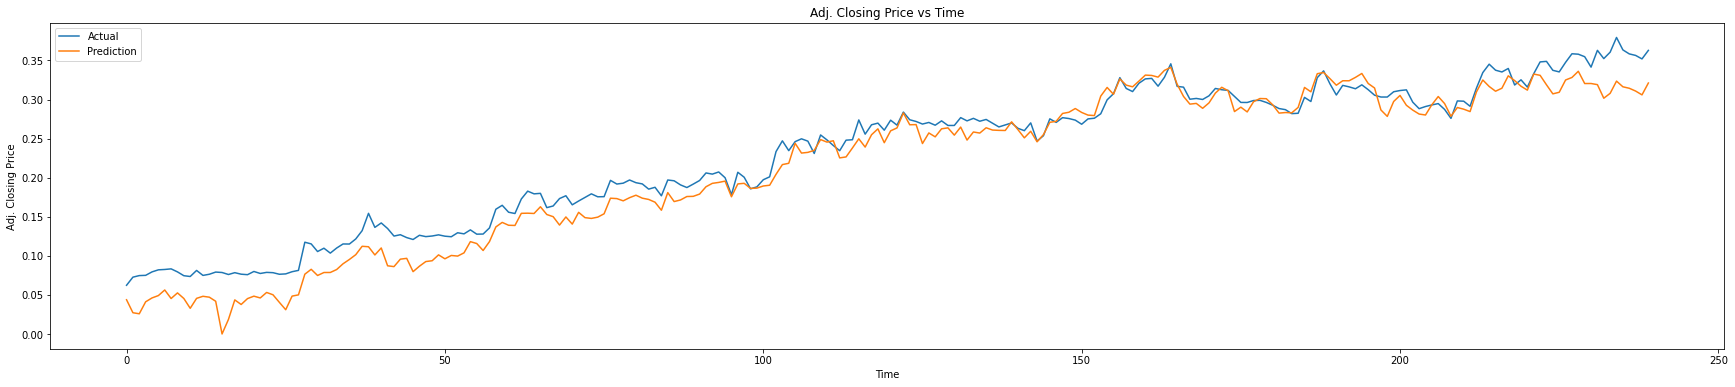

In [ ]:
plt.figure(1, figsize=(30, 6)) # Defines the figure size in inches
plt.plot(range(0, len(Y_test_gru_target)), Y_test_gru_target)
plt.plot(range(0, len(Y_test_gru_target)), Y_pred_test_gru_target)
plt.xlabel('Time')
plt.ylabel('Adj. Closing Price')
plt.title('Adj. Closing Price vs Time')
plt.legend(['Actual', 'Prediction'])

opt = tf.keras.optimizers.Adam(learning_rate=0.000009)

gru_model_target_transfer = Sequential()
gru_model_target_transfer.add(gru_model_source.layers[0])
gru_model_target_transfer.add(GRU(units=28, return_sequences=True, name="second"))
gru_model_target_transfer.add(GRU(units=28, name="third"))
gru_model_target_transfer.add(Dense(1, activation="relu", name="fourth"))
# gru_model_target.compile(optimizer="adam", loss='mean_squared_error', metrics=['mean_absolute_percentage_error'])
gru_model_target_transfer.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_absolute_percentage_error'])

In [ ]:
X_train_gru_target, X_test_gru_target, Y_train_gru_target, Y_test_gru_target = train_test_split(target_features, target_labels, test_size=0.30, random_state=42, shuffle=False)

In [ ]:
X_train_gru_target = np.array(X_train_gru_target)
X_test_gru_target = np.array(X_test_gru_target)
Y_train_gru_target = np.array(Y_train_gru_target)
Y_test_gru_target = np.array(Y_test_gru_target)

X_train_gru_target = X_train_gru_target.reshape(X_train_gru_target.shape[0],X_train_gru_target.shape[1],1)
X_test_gru_target = X_test_gru_target.reshape(X_test_gru_target.shape[0],X_test_gru_target.shape[1],1)

#### Hyper parameter tuning for learning rate of target model

In [ ]:
"""
Function used by Hyperband for hyperparameter tuning.
Returns a model.
"""
def target_model_builder_learning_rate(hp):                                           
    model = Sequential()
    """
    A Sequential gru_model_source is appropriate for a plain stack
    of layers where each layer has exactly one input tensor and
    one output tensor.
    """ 
    model.add(GRU(units=28, return_sequences=True,input_shape=(feature_count, 1)))
    model.add(GRU(units=28,return_sequences=True))
    model.add(GRU(units=28))
    model.add(Dense(1, activation="relu"))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.0005, 0.0001, 0.0005, 0.0001])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate), loss="mse", metrics=['mean_absolute_error', 'mean_absolute_percentage_error'])
    
    return model

In [ ]:
target_tuner_for_learning_rate = kt.Hyperband(target_model_builder_learning_rate,
                     objective='loss',
                     max_epochs=200,
                     factor=2,
                     seed=42,
                     hyperband_iterations=3,
                     directory='hyperparams',
                     project_name='target_stock_tuning')

In [ ]:
target_tuner_for_learning_rate.search(X_train_gru_target, Y_train_gru_target, epochs=250)

In [ ]:
# Get the optimal hyperparameters
best_hps_target=target_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal learning rate for the optimizer
is {best_hps_target.get('learning_rate')}.
""")

In [ ]:
target_tuner.search_space_summary()

In [ ]:
gru_models_target_best = target_tuner.get_best_models(num_models=2)

In [ ]:
gru_models_target_best[0].fit(X_train_gru_target,Y_train_gru_target,validation_data=(X_test_gru_target,Y_test_gru_target),epochs=200,verbose=1)

In [ ]:
Y_pred_test_gru_target_transfer_best = gru_models_target_best[0].predict(X_test_gru_target)
Y_pred_train_gru_target_transfer_best = gru_models_target_best[0].predict(X_train_gru_target)

In [ ]:
# Calculating RMSE
test_rmse_gru_target_transfer_best = sqrt(mean_squared_error(Y_pred_test_gru_target_transfer_best, Y_test_gru_target))
train_rmse_gru_target_transfer_best = sqrt(mean_squared_error(Y_pred_train_gru_target_transfer_best, Y_train_gru_target))
print("test_rmse_gru_target_transfer_best = {}, train_rmse_gru_target_transfer_best = {}".format(test_rmse_gru_target_transfer_best, train_rmse_gru_target_transfer_best))

# Calculating r2_score
test_r2_score_gru_target = r2_score(Y_test_gru_target, Y_pred_test_gru_target)
train_r2_score_gru_target = r2_score(Y_train_gru_target, Y_pred_train_gru_target)
print("test_r2_score_gru_target = {}, train_r2_score_gru_target = {}".format(test_r2_score_gru_target , train_r2_score_gru_target))

# Calculating MAE
test_mae_target_transfer_best = sqrt(mean_squared_error(Y_pred_test_gru_target_transfer_best, Y_test_gru_target))
train_mae_target_transfer_best = sqrt(mean_squared_error(Y_pred_train_gru_target_transfer_best, Y_train_gru_target))
print("test_mae_target_transfer_best = {}, train_mae_target_transfer_best = {}".format(test_mae_target_transfer_best, train_mae_target_transfer_best))

# Calculating MAPE
test_loss_target_transfer_best, test_mape_target_transfer_best = gru_model_target.evaluate(X_test_gru_target, Y_test_gru_target, verbose=0)
train_loss_target_transfer_best, train_mape_target_transfer_best = gru_model_target.evaluate(X_train_gru_target, Y_train_gru_target, verbose=0)
print("test_mape_target_transfer_best = {}, train_mape_target_transfer_best = {}".format(test_mape_target_transfer_best, train_mape_target_transfer_best))

In [ ]:
plt.figure(1, figsize=(30, 6)) # Defines the figure size in inches
plt.plot(range(0, len(Y_test_gru_target)), Y_test_gru_target)
plt.plot(range(0, len(Y_test_gru_target)), Y_pred_test_gru_target_transfer_best)
plt.xlabel('Time')
plt.ylabel('Adj. Closing Price')
plt.title('Adj. Closing Price vs Time')
plt.legend(['Actual', 'Prediction'])

#### Explainable AI (post-hoc model explanation using LIME)

#### Imports

In [ ]:
import lime
import lime.lime_tabular